## Final Project

This notebook is about expore relationship between private vehicle accidents and household income. Beacuse the file will be too large to upload if include all the plot together, so I seperate private vehcile accidents and public transit accidents. This notebook also include some map about public transit accidents that didn't include in the previous notebook.

In [23]:
import pandas as pd
import geopandas as gpd
import os
import folium 
import matplotlib.pyplot as plt
from sodapy import Socrata
from shapely.geometry import Point
from scipy.stats import gaussian_kde
import numpy as np

In [3]:
# read and add shapefile to notebook
file = gpd.read_file('Data/Major_Safety_Events.csv')
file

,NTD ID,Agency,Primary UZA UACE Code,Rail/Bus/Ferry,Mode Name,Mode,Type of Service,Fixed Route Flag,Year,Event Description,...,Occupant of Other Vehicle Serious Injuries,Other Injuries,Other Serious Injuries,Suicide Injuries,Suicide Serious Injuries,Total Serious Injuries,Person List,United States,US Counties,geometry
0,90154,Los Angeles County Metropolitan Transportation...,51445,Rail,Light Rail,LR,DO,TRUE,2023,{Redacted} {Redacted} investigation revealed t...,...,0,0,0,0,0,0,,6,2090,None
1,90154,Los Angeles County Metropolitan Transportation...,51445,Bus,Bus,MB,DO,TRUE,2023,Bus operator hit the brakes hard to avoid a ve...,...,0,0,0,0,0,0,I Passenger Senior Citizen (61 and up) F ; ...,6,2090,None
2,90154,Los Angeles County Metropolitan Transportation...,51445,Bus,Bus,MB,DO,TRUE,2022,Suspect assaulted victim while riding the bus ...,...,0,0,0,0,0,0,I Passenger Adult (19 to 60) M,6,2090,None
3,90154,Los Angeles County Metropolitan Transportation...,51445,Rail,Light Rail,LR,DO,TRUE,2022,{Redacted} was attacked by suspect while ridin...,...,0,0,0,0,0,0,I Passenger Adult (19 to 60) M Y,6,2090,None
4,90154,Los Angeles County Metropolitan Transportation...,51445,Rail,Light Rail,LR,DO,TRUE,2022,{Redacted} was attacked by suspect while ridin...,...,0,0,0,0,0,0,I Passenger Adult (19 to 60) M Y,6,2090,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2249,90154,Los Angeles County Metropolitan Transportation...,51445,Rail,Light Rail,LR,DO,TRUE,2014,{Redacted} was standing on the south side of t...,...,0,0,0,0,0,0,I Wait Leave Adult (19 to 60) M,,,None
2250,90154,Los Angeles County Metropolitan Transportation...,51445,Bus,Bus,MB,DO,TRUE,2014,The victim was riding her bicycle by the {Reda...,...,0,0,0,0,0,0,I Wait Leave Teen (13 to 18) F,,,None
2251,90154,Los Angeles County Metropolitan Transportation...,51445,Bus,Bus,MB,DO,TRUE,2014,{Redacted} ( Bus ) EB # {Redacted} lane of {Re...,...,0,0,0,0,0,0,I Passenger Adult (19 to 60) F ; I Passe...,,,None
2252,90154,Los Angeles County Metropolitan Transportation...,51445,Rail,Light Rail,LR,DO,TRUE,2014,A {Redacted} ) was at {Redacted} {Redacted} tr...,...,0,0,0,0,0,0,I Wait Leave Adult (19 to 60) F,,,None


In [4]:
# list of desired column names
desired_columns =['Mode Name','Mode','Year','Event Type Group','Latitude','Longitude','LatLon']

In [5]:
# trimming the dataset
data_trimmed = file[desired_columns].copy()
data_trimmed

,Mode Name,Mode,Year,Event Type Group,Latitude,Longitude,LatLon
0,Light Rail,LR,2023,Collision,34.03336,-118.16377,POINT (-118.16377 34.03336)
1,Bus,MB,2023,Other,34.02805,-118.21938,POINT (-118.21938 34.02805)
2,Bus,MB,2022,Assault,33.930941,-118.309252,POINT (-118.309252 33.930941)
3,Light Rail,LR,2022,Assault,33.928945,-118.238038,POINT (-118.238038 33.928945)
4,Light Rail,LR,2022,Assault,34.013961,-118.491508,POINT (-118.491508 34.013961)
...,...,...,...,...,...,...,...
2249,Light Rail,LR,2014,Assault,,,
2250,Bus,MB,2014,Security,,,
2251,Bus,MB,2014,Collision,,,
2252,Light Rail,LR,2014,Security,,,


In [6]:
# show rows that Latitude is not empty
data_trimmed[data_trimmed.Latitude != '']

,Mode Name,Mode,Year,Event Type Group,Latitude,Longitude,LatLon
0,Light Rail,LR,2023,Collision,34.03336,-118.16377,POINT (-118.16377 34.03336)
1,Bus,MB,2023,Other,34.02805,-118.21938,POINT (-118.21938 34.02805)
2,Bus,MB,2022,Assault,33.930941,-118.309252,POINT (-118.309252 33.930941)
3,Light Rail,LR,2022,Assault,33.928945,-118.238038,POINT (-118.238038 33.928945)
4,Light Rail,LR,2022,Assault,34.013961,-118.491508,POINT (-118.491508 34.013961)
...,...,...,...,...,...,...,...
2020,Light Rail,LR,2015,Collision,34.03998,-118.266814,POINT (-118.266814 34.03998)
2021,Heavy Rail,HR,2015,Security,34.1011194,-118.3258063,POINT (-118.3258063 34.1011194)
2027,Bus,MB,2015,Collision,34.0436431,-118.3089835,POINT (-118.3089835 34.0436431)
2039,Light Rail,LR,2015,Collision,34.03104,-118.264604,POINT (-118.264604 34.03104)


In [7]:
# show data only from 2018 to 2022
data_trimmed[data_trimmed['Year'].isin(['2018', '2019', '2020', '2021', '2022'])]

,Mode Name,Mode,Year,Event Type Group,Latitude,Longitude,LatLon
2,Bus,MB,2022,Assault,33.930941,-118.309252,POINT (-118.309252 33.930941)
3,Light Rail,LR,2022,Assault,33.928945,-118.238038,POINT (-118.238038 33.928945)
4,Light Rail,LR,2022,Assault,34.013961,-118.491508,POINT (-118.491508 34.013961)
5,Bus,MB,2022,Assault,33.975102,-118.123203,POINT (-118.123203 33.975102)
6,Light Rail,LR,2022,Assault,33.933595,-118.352083,POINT (-118.352083 33.933595)
...,...,...,...,...,...,...,...
1213,Light Rail,LR,2018,Assault,33.84731,-118.211014,POINT (-118.211014 33.84731)
1270,Bus,MB,2018,Collision,34.149178,-118.469125,POINT (-118.469125 34.149178)
1289,Bus,MB,2018,Collision,34.04727,-118.291621,POINT (-118.291621 34.04727)
1298,Bus,MB,2018,Collision,34.047254,-118.246203,POINT (-118.246203 34.047254)


In [8]:
# trimming the dataset
new_data_trimmed = data_trimmed[data_trimmed['Year'].isin(['2018', '2019', '2020', '2021', '2022'])].copy()
new_data_trimmed

,Mode Name,Mode,Year,Event Type Group,Latitude,Longitude,LatLon
2,Bus,MB,2022,Assault,33.930941,-118.309252,POINT (-118.309252 33.930941)
3,Light Rail,LR,2022,Assault,33.928945,-118.238038,POINT (-118.238038 33.928945)
4,Light Rail,LR,2022,Assault,34.013961,-118.491508,POINT (-118.491508 34.013961)
5,Bus,MB,2022,Assault,33.975102,-118.123203,POINT (-118.123203 33.975102)
6,Light Rail,LR,2022,Assault,33.933595,-118.352083,POINT (-118.352083 33.933595)
...,...,...,...,...,...,...,...
1213,Light Rail,LR,2018,Assault,33.84731,-118.211014,POINT (-118.211014 33.84731)
1270,Bus,MB,2018,Collision,34.149178,-118.469125,POINT (-118.469125 34.149178)
1289,Bus,MB,2018,Collision,34.04727,-118.291621,POINT (-118.291621 34.04727)
1298,Bus,MB,2018,Collision,34.047254,-118.246203,POINT (-118.246203 34.047254)


In [9]:
# covert Latitude and Longitude from object to float
new_data_trimmed['Latitude']= new_data_trimmed.Latitude.astype(float)
new_data_trimmed['Longitude']= new_data_trimmed.Longitude.astype(float)

In [10]:
# convert object to WKT strings
new_data_trimmed['LatLon'] = new_data_trimmed['LatLon'].apply(lambda x: x.wkt if hasattr(x, 'wkt') else x)

In [11]:
# convert object to geometry for column LatLon
from shapely.geometry import Point
from shapely import wkt
new_data_trimmed['geometry'] = new_data_trimmed['LatLon'].apply(wkt.loads)
gnew_data_trimmed = gpd.GeoDataFrame(new_data_trimmed, geometry='geometry')

In [12]:
# check data type of each column again
gnew_data_trimmed.dtypes

Mode Name             object
Mode                  object
Year                  object
Event Type Group      object
Latitude             float64
Longitude            float64
LatLon                object
geometry            geometry
dtype: object

In [2]:
# read and add shapefile to notebook
df = pd.read_csv('Data/R13559086_SL140.csv')

In [3]:
# try to see all the data and display a sample row
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df.sample()

,Geo_FIPS,Geo_QName,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_US,Geo_REGION,Geo_DIVISION,Geo_STATE,Geo_COUNTY,Geo_COUSUB,Geo_PLACE,Geo_TRACT,Geo_BLKGRP,Geo_CONCIT,Geo_AIANHH,Geo_AIANHHFP,Geo_AIHHTLI,Geo_AITS,Geo_ANRC,Geo_CBSA,Geo_CSA,Geo_METDIV,Geo_MACC,Geo_MEMI,Geo_NECTA,Geo_CNECTA,Geo_NECTADIV,Geo_UA,Geo_CDCURR,Geo_SLDU,Geo_SLDL,Geo_ZCTA3,Geo_ZCTA5,Geo_SUBMCD,Geo_SDELM,Geo_SDSEC,Geo_SDUNI,Geo_UR,Geo_PCI,Geo_PUMA5,Geo_NAME,Geo_BTTR,Geo_BTBG,Geo_PLACESE,SE_A14001_001,SE_A14001_002,SE_A14001_003,SE_A14001_004,SE_A14001_005,SE_A14001_006,SE_A14001_007,SE_A14001_008,SE_A14001_009,SE_A14001_010,SE_A14001_011,SE_A14001_012,SE_A14001_013,SE_A14001_014,SE_A14001_015,SE_A14001_016,SE_A14001_017,PCT_SE_A14001_002,PCT_SE_A14001_003,PCT_SE_A14001_004,PCT_SE_A14001_005,PCT_SE_A14001_006,PCT_SE_A14001_007,PCT_SE_A14001_008,PCT_SE_A14001_009,PCT_SE_A14001_010,PCT_SE_A14001_011,PCT_SE_A14001_012,PCT_SE_A14001_013,PCT_SE_A14001_014,PCT_SE_A14001_015,PCT_SE_A14001_016,PCT_SE_A14001_017,Low-Income,Middle-Income,High-Income
602,6037207502,"Census Tract 2075.02, Los Angeles County, Cali...",ca,140,0,NaN,NaN,NaN,6,37,NaN,NaN,207502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Census Tract 2075.02,NaN,NaN,NaN,2463,213,774,280,156,17,0,57,160,26,57,165,90,118,54,67,229,8.65,31.43,11.37,6.33,0.69,0.0,2.31,6.5,1.06,2.31,6.7,3.65,4.79,2.19,2.72,9.3,1683,484,296


In [4]:
# convert FIPS, STATE, and COUNTY to string
df = pd.read_csv(
    'Data/R13559086_SL140.csv',
    dtype=
    {
        'Geo_FIPS':str,
        'Geo_STATE':str,
        'Geo_COUNTY': str
    }
)

In [5]:
# confirm the columns have correct data type
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 81 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Geo_FIPS           2498 non-null   object 
 1   Geo_QName          2498 non-null   object 
 2   Geo_STUSAB         2498 non-null   object 
 3   Geo_SUMLEV         2498 non-null   int64  
 4   Geo_GEOCOMP        2498 non-null   int64  
 5   Geo_US             0 non-null      float64
 6   Geo_REGION         0 non-null      float64
 7   Geo_DIVISION       0 non-null      float64
 8   Geo_STATE          2498 non-null   object 
 9   Geo_COUNTY         2498 non-null   object 
 10  Geo_COUSUB         0 non-null      float64
 11  Geo_PLACE          0 non-null      float64
 12  Geo_TRACT          2498 non-null   int64  
 13  Geo_BLKGRP         0 non-null      float64
 14  Geo_CONCIT         0 non-null      float64
 15  Geo_AIANHH         0 non-null      float64
 16  Geo_AIANHHFP       0 non

In [6]:
# check which columns are null columns
df.columns[df.isna().all()].tolist()

['Geo_US',
 'Geo_REGION',
 'Geo_DIVISION',
 'Geo_COUSUB',
 'Geo_PLACE',
 'Geo_BLKGRP',
 'Geo_CONCIT',
 'Geo_AIANHH',
 'Geo_AIANHHFP',
 'Geo_AIHHTLI',
 'Geo_AITS',
 'Geo_ANRC',
 'Geo_CBSA',
 'Geo_CSA',
 'Geo_METDIV',
 'Geo_MACC',
 'Geo_MEMI',
 'Geo_NECTA',
 'Geo_CNECTA',
 'Geo_NECTADIV',
 'Geo_UA',
 'Geo_CDCURR',
 'Geo_SLDU',
 'Geo_SLDL',
 'Geo_ZCTA3',
 'Geo_ZCTA5',
 'Geo_SUBMCD',
 'Geo_SDELM',
 'Geo_SDSEC',
 'Geo_SDUNI',
 'Geo_UR',
 'Geo_PCI',
 'Geo_PUMA5',
 'Geo_BTTR',
 'Geo_BTBG',
 'Geo_PLACESE']

In [7]:
# delete null columns
df = df.dropna(axis=1,how="all")

In [8]:
# define the columns that I want to keep
columns_to_keep = ['Geo_FIPS',
                   'SE_A14001_001',
                   'SE_A14001_002',
                   'SE_A14001_003',
                   'SE_A14001_004',
                   'SE_A14001_005',
                   'SE_A14001_006',
                   'SE_A14001_007',
                   'SE_A14001_008',
                   'SE_A14001_009',
                   'SE_A14001_010',
                   'SE_A14001_011',
                   'SE_A14001_012',
                   'SE_A14001_013',
                   'SE_A14001_014',
                   'SE_A14001_015',
                   'SE_A14001_016',
                   'SE_A14001_017',
                   'Low-Income',
                   'Middle-Income',
                   'High-Income']

In [9]:
# save these columns
df2 = df[columns_to_keep]

In [10]:
# rename these columns associate with household income
df2.columns = ['FIPS',
'Total_Household',
'Less than $10,000',
'$10,000 to $14,999',
'$15,000 to $19,999',
'$20,000 to $24,999',
'$25,000 to $29,999',
'$30,000 to $34,999',
'$35,000 to $39,999',
'$40,000 to $44,999',
'$45,000 to $49,999',
'$50,000 to $59,999',
'$60,000 to $74,999',
'$75,000 to $99,999',
'$100,000 to $124,999',
'$125,000 to $149,999',
'$150,000 to $199,999',
'$200,000 or More',
'Low-Income',
'Middle-Income',
'High-Income']

In [12]:
# read in a geojson file 
tracts=gpd.read_file('Data/Census_Tracts_2020.geojson')
tracts.head()

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry
0,1,101110,1011.10,1.229562e+07,15083.854287,"POLYGON ((-118.28491 34.25948, -118.28492 34.2..."
1,2,101122,1011.22,2.845774e+07,31671.455844,"POLYGON ((-118.29015 34.27417, -118.29015 34.2..."
2,3,101220,1012.20,7.522093e+06,12698.783810,"POLYGON ((-118.28100 34.25592, -118.28198 34.2..."
3,4,101221,1012.21,3.812000e+06,9161.710543,"POLYGON ((-118.28735 34.25591, -118.28863 34.2..."
4,5,101222,1012.22,3.191371e+06,9980.600461,"POLYGON ((-118.28594 34.25405, -118.28594 34.2..."


In [13]:
# only keep FIPS and geometry
tracts = tracts[['CT20','geometry']]
tracts.head()

,CT20,geometry
0,101110,"POLYGON ((-118.28491 34.25948, -118.28492 34.2..."
1,101122,"POLYGON ((-118.29015 34.27417, -118.29015 34.2..."
2,101220,"POLYGON ((-118.28100 34.25592, -118.28198 34.2..."
3,101221,"POLYGON ((-118.28735 34.25591, -118.28863 34.2..."
4,101222,"POLYGON ((-118.28594 34.25405, -118.28594 34.2..."


In [14]:
# create a FIPS column
tracts['FIPS'] ='06' + '037' + tracts['CT20']

In [15]:
# create a new dataframe based on the join
tracts['FIPS'] = tracts['FIPS'].astype(int)
df2['FIPS'] = df2['FIPS'].astype(int)

# Merge the DataFrames
tracts_income = tracts.merge(df2, on='FIPS')

/tmp/ipykernel_103/2312057885.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['FIPS'] = df2['FIPS'].astype(int)


## Public Transit Accident Map

In [45]:
minx, miny, maxx, maxy = gnew_data_trimmed.total_bounds
print([minx, miny, maxx, maxy])

[-118.9987929, 33.06929, -117.57462, 37.361517]


<Figure size 3000x3000 with 0 Axes>

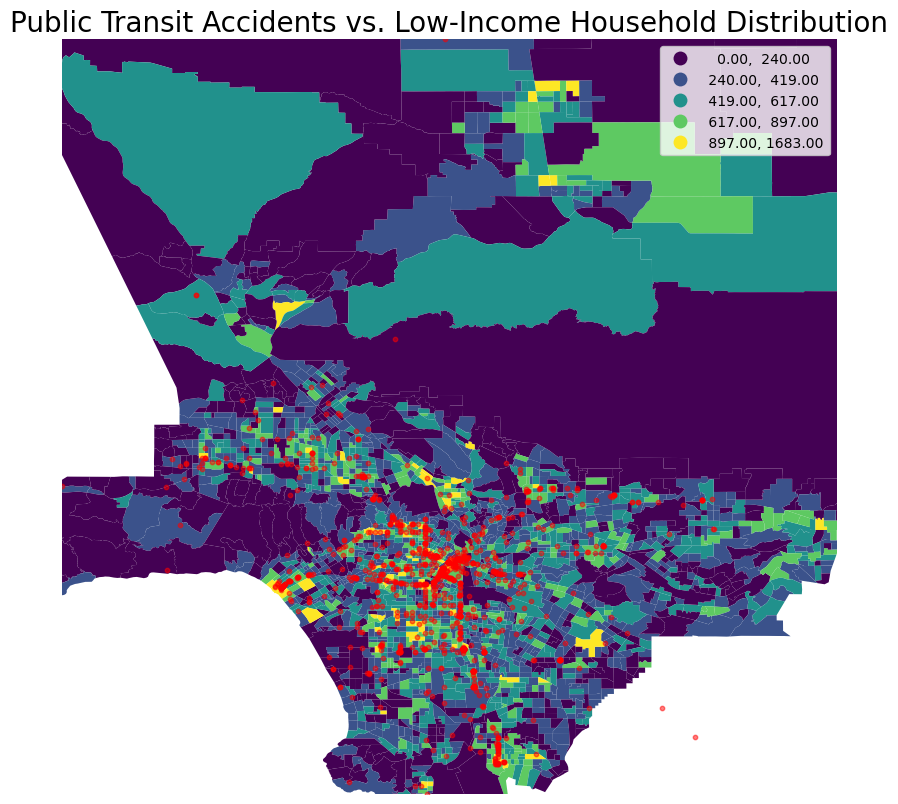

In [59]:
plt.figure(figsize=(30, 30))

public_accidents_bounds = [-118.796754, 33.72697, -117.719291, 34.776]

# Plot the choropleth map
ax = tracts_income.plot(column='Low-Income',
                        scheme='NaturalBreaks', 
                        figsize=(10, 10),
                        legend=True)

# set the boundaries 
ax.set_xlim([public_accidents_bounds[0], public_accidents_bounds[2]])
ax.set_ylim([public_accidents_bounds[1], public_accidents_bounds[3]])

# add a title 
ax.set_title('Public Transit Accidents vs. Low-Income Household Distribution', fontsize=20)

# Plot the accident points on top of the choropleth
gnew_data_trimmed.plot(ax=ax, 
                       marker='o', 
                       color='red', 
                       markersize=10, 
                       alpha=0.5)

# turn the axes off
ax.axis('off')

plt.savefig('Public_Transit_Incidents_with_Low_Distribution_LA')

plt.show()

<Figure size 3000x3000 with 0 Axes>

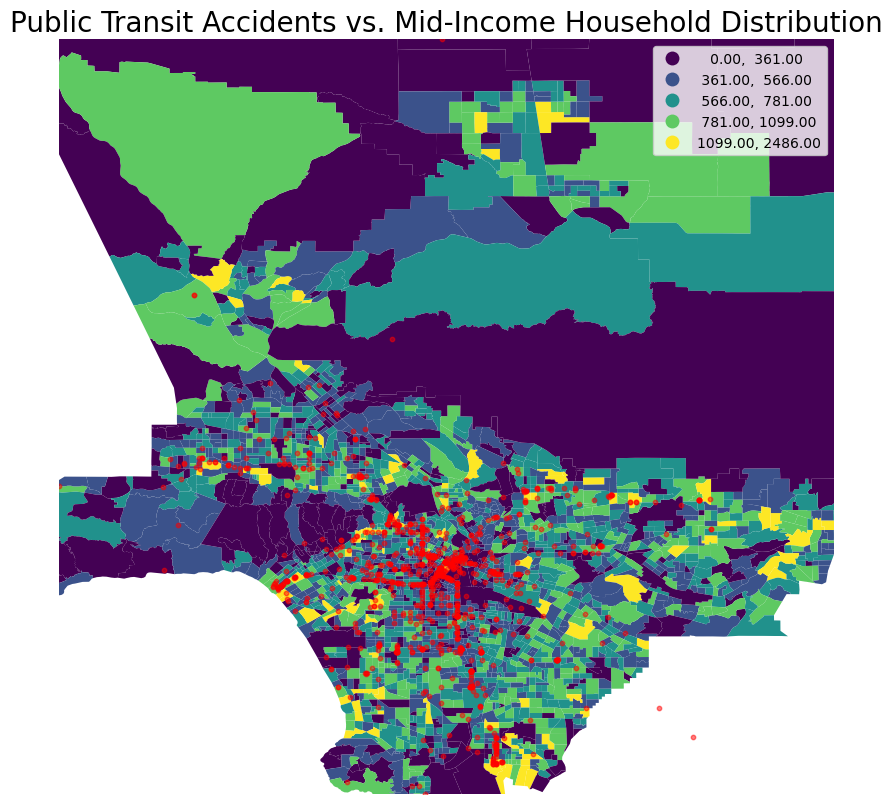

In [60]:
plt.figure(figsize=(30, 30))

public_accidents_bounds = [-118.796754, 33.72697, -117.719291, 34.776]

# Plot the choropleth map
ax = tracts_income.plot(column='Middle-Income',
                        scheme='NaturalBreaks', 
                        figsize=(10, 10),
                        legend=True)

# set the boundaries 
ax.set_xlim([public_accidents_bounds[0], public_accidents_bounds[2]])
ax.set_ylim([public_accidents_bounds[1], public_accidents_bounds[3]])

# add a title 
ax.set_title('Public Transit Accidents vs. Mid-Income Household Distribution', fontsize=20)

# Plot the accident points on top of the choropleth
gnew_data_trimmed.plot(ax=ax, 
                       marker='o', 
                       color='red', 
                       markersize=10, 
                       alpha=0.5)

# turn the axes off
ax.axis('off')

plt.savefig('Public_Transit_Incidents_with_Mid_Distribution_LA')

plt.show()

<Figure size 3000x3000 with 0 Axes>

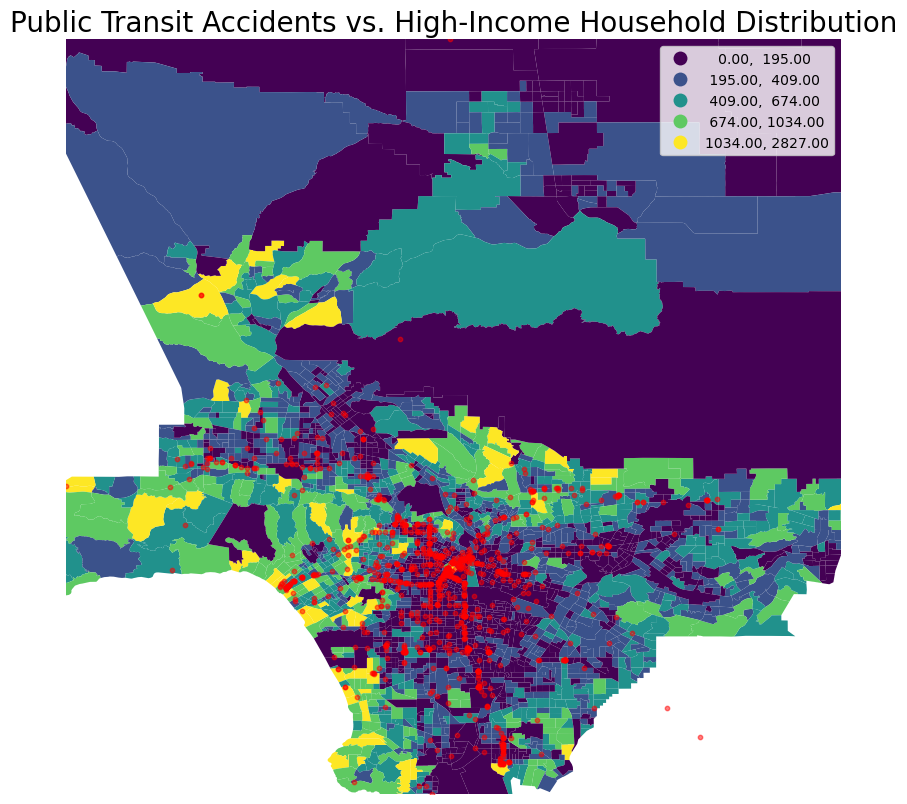

In [61]:
plt.figure(figsize=(30, 30))

public_accidents_bounds = [-118.796754, 33.72697, -117.719291, 34.776]

# Plot the choropleth map
ax = tracts_income.plot(column='High-Income',
                        scheme='NaturalBreaks', 
                        figsize=(10, 10),
                        legend=True)

# set the boundaries 
ax.set_xlim([public_accidents_bounds[0], public_accidents_bounds[2]])
ax.set_ylim([public_accidents_bounds[1], public_accidents_bounds[3]])

# add a title 
ax.set_title('Public Transit Accidents vs. High-Income Household Distribution', fontsize=20)

# Plot the accident points on top of the choropleth
gnew_data_trimmed.plot(ax=ax, 
                       marker='o', 
                       color='red', 
                       markersize=10, 
                       alpha=0.5)

# turn the axes off
ax.axis('off')

plt.savefig('Public_Transit_Incidents_with_High_Distribution_LA')

plt.show()

Low-income distribution choropleth map is more consistent with the traffic accidents distribution pattern, both of them are concentrated in the central area of Los Angeles.

## Private Vehicle Map

In [27]:
# importing data
private = pd.read_csv('Data/Traffic_Collision_Data_2018_to_2022.csv')

In [28]:
def parse_location(location_str):
    try:
        lat, lon = map(float, location_str.strip("()").split(", "))
        return Point(lon, lat)
    except:
        return None

In [29]:
# Apply the function
private['geometry'] = private['Location'].apply(parse_location)

# Remove unneeded lines
private_accident = private.dropna(subset=['geometry'])

# Conversion of incident data into geographic data
private_accident = gpd.GeoDataFrame(private, geometry='geometry')

In [32]:
private_accident = private_accident[(private_accident.geometry.x != 0) & (private_accident.geometry.y != 0)]

In [33]:
minx, miny, maxx, maxy = private_accident.total_bounds
print([minx, miny, maxx, maxy])

[-118.6663, 33.7065, -118.1554, 34.3372]


<Figure size 3000x3000 with 0 Axes>

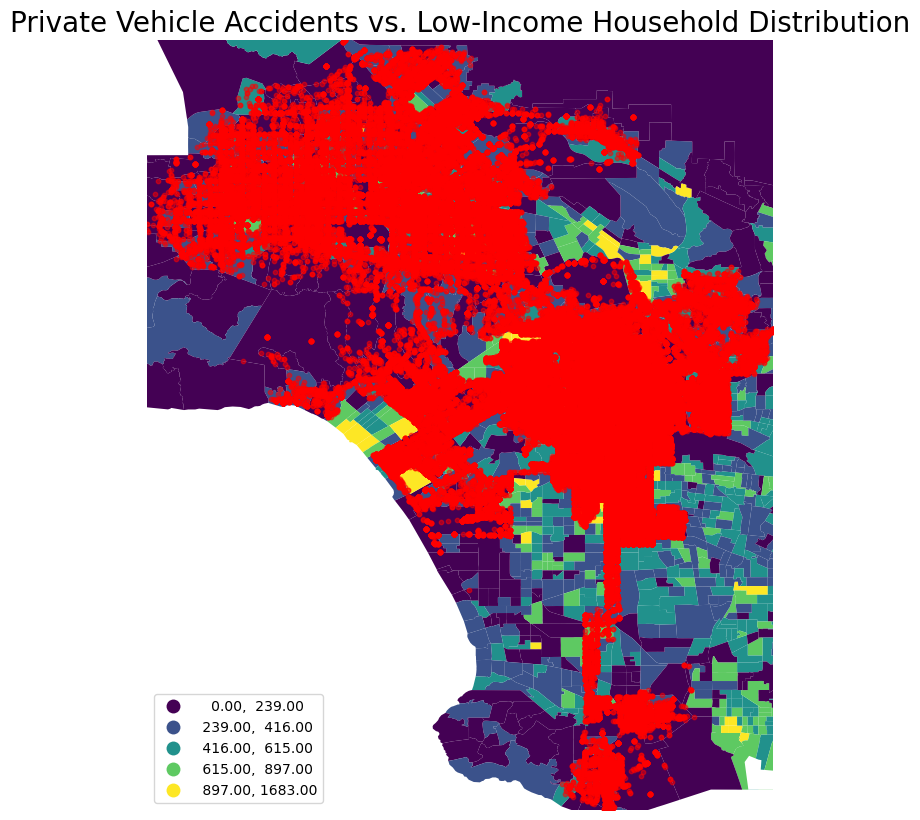

In [35]:
plt.figure(figsize=(30, 30))

private_accidents_bounds = [-118.6663, 33.7065, -118.1554, 34.3343]

# Plot the choropleth map
ax = tracts_income.plot(column='Low-Income',
                        scheme='NaturalBreaks', 
                        figsize=(10, 10),
                        legend=True)

# set the boundaries 
ax.set_xlim([private_accidents_bounds[0], private_accidents_bounds[2]])
ax.set_ylim([private_accidents_bounds[1], private_accidents_bounds[3]])

# add a title 
ax.set_title('Private Vehicle Accidents vs. Low-Income Household Distribution', fontsize=20)

# Plot the accident points on top of the choropleth
private_accident.plot(ax=ax, 
                       marker='o', 
                       color='red', 
                       markersize=10, 
                       alpha=0.5)

# turn the axes off
ax.axis('off')

plt.savefig('Private_Transit_Incidents_with_Low_Distribution_LA')

plt.show()

<Figure size 3000x3000 with 0 Axes>

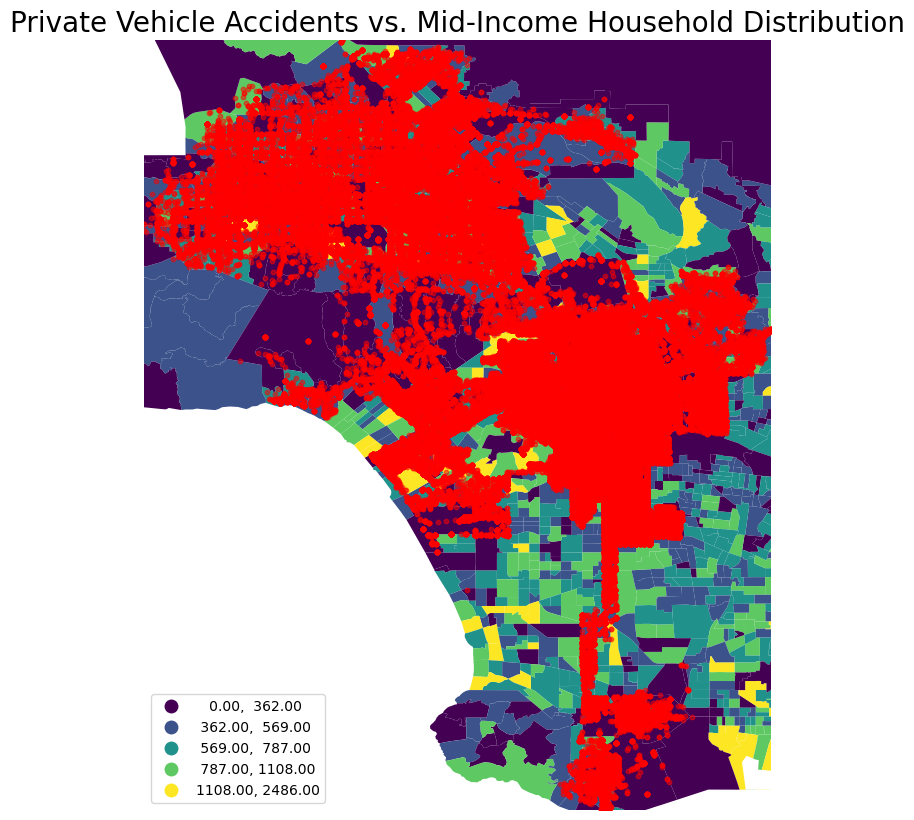

In [36]:
plt.figure(figsize=(30, 30))

private_accidents_bounds = [-118.6663, 33.7065, -118.1554, 34.3343]

# Plot the choropleth map
ax = tracts_income.plot(column='Middle-Income',
                        scheme='NaturalBreaks', 
                        figsize=(10, 10),
                        legend=True)

# set the boundaries 
ax.set_xlim([private_accidents_bounds[0], private_accidents_bounds[2]])
ax.set_ylim([private_accidents_bounds[1], private_accidents_bounds[3]])

# add a title 
ax.set_title('Private Vehicle Accidents vs. Mid-Income Household Distribution', fontsize=20)

# Plot the accident points on top of the choropleth
private_accident.plot(ax=ax, 
                       marker='o', 
                       color='red', 
                       markersize=10, 
                       alpha=0.5)

# turn the axes off
ax.axis('off')

plt.savefig('Private_Transit_Incidents_with_Mid_Distribution_LA')

plt.show()

<Figure size 3000x3000 with 0 Axes>

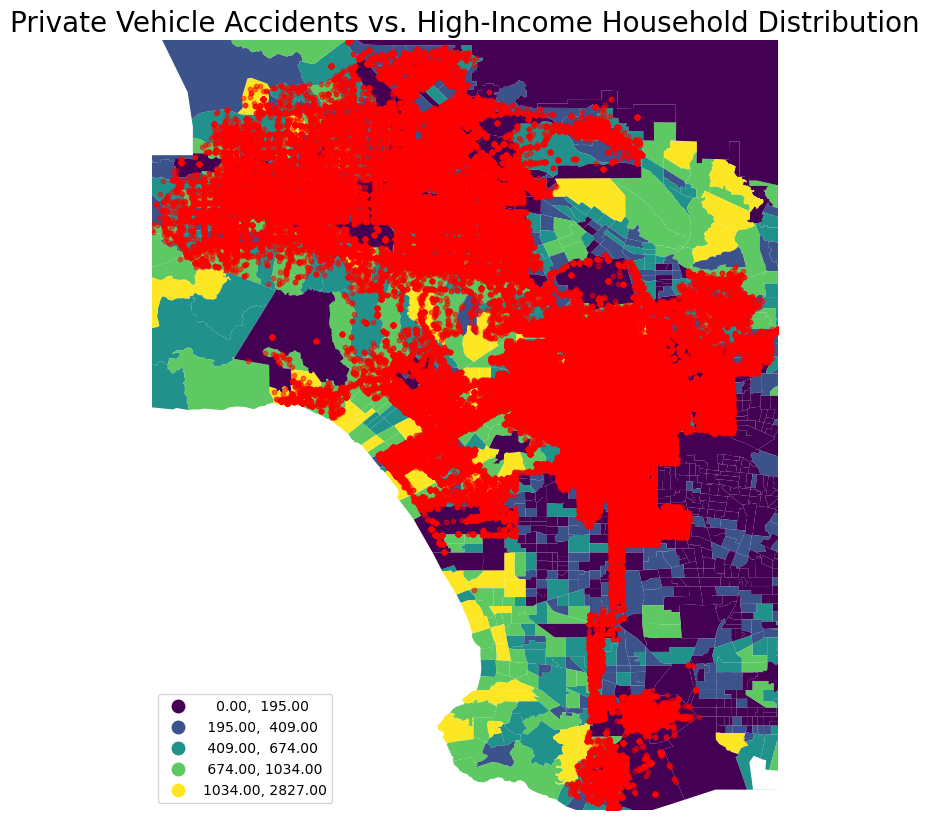

In [37]:
plt.figure(figsize=(30, 30))

private_accidents_bounds = [-118.6663, 33.7065, -118.1554, 34.3343]

# Plot the choropleth map
ax = tracts_income.plot(column='High-Income',
                        scheme='NaturalBreaks', 
                        figsize=(10, 10),
                        legend=True)

# set the boundaries 
ax.set_xlim([private_accidents_bounds[0], private_accidents_bounds[2]])
ax.set_ylim([private_accidents_bounds[1], private_accidents_bounds[3]])

# add a title 
ax.set_title('Private Vehicle Accidents vs. High-Income Household Distribution', fontsize=20)

# Plot the accident points on top of the choropleth
private_accident.plot(ax=ax, 
                       marker='o', 
                       color='red', 
                       markersize=10, 
                       alpha=0.5)

# turn the axes off
ax.axis('off')

plt.savefig('Private_Transit_Incidents_with_High_Distribution_LA')

plt.show()

Due to the large amount of private vehicle traffic accident data from 2018 to 2022, it is difficult to directly find its distribution characteristics in the above map, and it is also difficult to figure out the relationship between the household income and the accident rate. But we can still conclude that a large proportion of private vehicle traffic accidents are distributed in central Los Angeles, which is consistent with the distribution of low-income household. 